# データの準備

In [1]:
import pandas as pd

# データの読み込み
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [2]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

In [3]:
# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]
# index を振り直す
df_wrime_target = df_wrime_target.reset_index(drop=True)

In [4]:
df_wrime_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sentence                     18237 non-null  object
 1   UserID                       18237 non-null  int64 
 2   Datetime                     18237 non-null  object
 3   Train/Dev/Test               18237 non-null  object
 4   Writer_Joy                   18237 non-null  int64 
 5   Writer_Sadness               18237 non-null  int64 
 6   Writer_Anticipation          18237 non-null  int64 
 7   Writer_Surprise              18237 non-null  int64 
 8   Writer_Anger                 18237 non-null  int64 
 9   Writer_Fear                  18237 non-null  int64 
 10  Writer_Disgust               18237 non-null  int64 
 11  Writer_Trust                 18237 non-null  int64 
 12  Reader1_Joy                  18237 non-null  int64 
 13  Reader1_Sadness              18

In [5]:
# リスト化
sentences = df_wrime_target['Sentence'].tolist()

In [6]:
# # 「\n」を「」に置換する
# sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# # 「x000D」を「」に置換する
# sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

# つぶやき分散表現

## モデル

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 使用するモデルを指定して、トークナイザとモデルを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking' # 'cl-tohoku/bert-base-japanese-v2'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, output_hidden_states=True) # output_hidden_states=Trueで分散表現を取得する

c:\Users\yossh\anaconda3\envs\bert_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing B

In [8]:
from transformers import TRANSFORMERS_CACHE
print(TRANSFORMERS_CACHE)

C:\Users\yossh/.cache\huggingface\hub


## 分散表現を取得

In [9]:
from torch.utils.data import DataLoader


# 入力文章をトークン化する関数
def tokenize(text):
    return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# データローダーを作成する
batch_size = 64
dataloader = DataLoader(sentences, batch_size=batch_size, collate_fn=tokenize)

# モデルをGPUに移動する
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# バッチ処理で分散表現を取得する
embeddings = []
with torch.no_grad():
    for batch in dataloader:
        # バッチをGPUに移動する
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states[-1][:, 0]) # 最後の層のCLSトークンのみ取得する

embeddings = torch.cat(embeddings)

# in 1min


In [10]:
# pandasのDataFrameに変換する
df_embeddings = pd.DataFrame(embeddings.tolist())

df_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 106.9 MB


In [11]:
# # 保存する
# df_embeddings.to_csv('embeddings/pretrained_embeddings.tsv', sep='\t', index=False)

### 文章間の類似度

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# target_indexの文章と類似度の高い文章を表示する
target_index = 1

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

index: 1
文　章：今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
類似度：1.0000000000000009
---
index: 7215
文　章：そろそろ家の近く散策してみようか、と思った日に雨。 家でおとなしくしていよう。
類似度：0.9288621008836279
---
index: 7761
文　章：こんな時間に睡魔が…。今寝てしまったら、夜眠れなくなる…。明日は髪狩様のところに10時に行かねばならぬというのに。眠い。
類似度：0.9281979754048781
---
index: 14186
文　章：昨日から声が掠れて、きょうは少し咳が出る。夏かぜだと思いたい……。24時間冷房いれっぱなしなのできっとそうよ（誰に言う）。
類似度：0.9266034477924784
---
index: 13767
文　章：台風（；＿；）（；＿；）（；＿；）
類似度：0.40800109935132745
---
index: 6302
文　章：QUEEN+ADAM LAMBERTのチケット取れた！
類似度：0.4819761373772622
---
index: 4770
文　章：餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子
類似度：0.4875270269867737
---


---

# クラスタリング

In [13]:
from sklearn.cluster import KMeans

# クラスタリング

# k: クラスター数 (optional)
k = 6

# k-means法の実行
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)
# 各サンプルのクラスター番号を取得する
clusters = kmeansModel.labels_

c:\Users\yossh\anaconda3\envs\bert_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


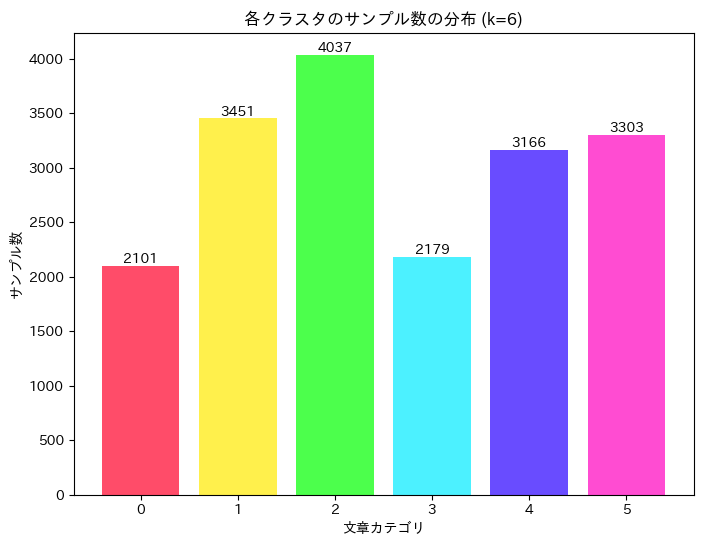

In [14]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# 可視化
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('文章カテゴリ')
plt.ylabel('サンプル数')
plt.title(f'各クラスタのサンプル数の分布 (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## クラスター数の決定

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

In [15]:
'''
# エルボー法による最適クラスター数の調査
SSE = []
for i in range(1, 40):
    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeansModel.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), SSE, marker='o', markersize=3)
plt.xlabel('クラスター数')
plt.ylabel('SSE')
plt.title('エルボー法による最適クラスター数の調査')
plt.show()
'''

"\n# エルボー法による最適クラスター数の調査\nSSE = []\nfor i in range(1, 40):\n    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    SSE.append(kmeansModel.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(1, 40), SSE, marker='o', markersize=3)\nplt.xlabel('クラスター数')\nplt.ylabel('SSE')\nplt.title('エルボー法による最適クラスター数の調査')\nplt.show()\n"

<img src="figures/pretrained_elbow.png">

### シルエット係数による最適クラスター数の調査

In [16]:
'''
from sklearn.metrics import silhouette_score

# シルエット係数による最適クラスター数の調査
silhouette_coefficients = []
for i in range(2, 40):
    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeansModel.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, 40), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('クラスター数')
plt.ylabel('シルエット係数の平均値')
plt.title('シルエット係数の平均値による最適クラスター数の調査')
plt.show()
'''

"\nfrom sklearn.metrics import silhouette_score\n\n# シルエット係数による最適クラスター数の調査\nsilhouette_coefficients = []\nfor i in range(2, 40):\n    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    silhouette_coefficient = silhouette_score(df_embeddings, kmeansModel.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, 40), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('クラスター数')\nplt.ylabel('シルエット係数の平均値')\nplt.title('シルエット係数の平均値による最適クラスター数の調査')\nplt.show()\n"

<img src = "figures/pretrained_silhouette.png">

### シルエット図

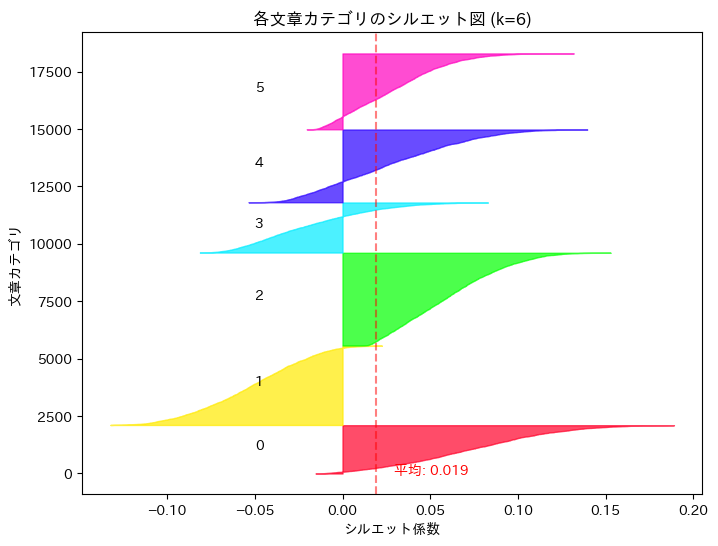

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"平均: {silhouette_avg:.3f}", color="red")

plt.xlabel('シルエット係数')
plt.ylabel('文章カテゴリ')
plt.title(f'各文章カテゴリのシルエット図 (k={k})')
plt.show()

In [18]:
# 各文章カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

文章カテゴリ: 0
シルエット係数が最も高い文章: (´-`).o0(おいでよ上田の中の人体験がもしできるならしてみたい人ってどのくらいいるかな…？)\n\n(´-`).o0(やるかどうかはまだ検討中だけど…)
シルエット係数: 0.189
---
文章カテゴリ: 1
シルエット係数が最も高い文章: 願掛け
シルエット係数: 0.022
---
文章カテゴリ: 2
シルエット係数が最も高い文章: 自分は何事にも切り替え下手なのでラブコメなどで出るラッキースケベは好きなんだけど、スポ根ものでは「いまそれいるんか？」ってなるんよな。嫌いではなくて困惑に近い。\nよく聞く「オタクに媚びてる感」ってうまく定義できないけど、そういうものも影響するのかしらと思った
シルエット係数: 0.153
---
文章カテゴリ: 3
シルエット係数が最も高い文章: キャスに来てくれた方、ありがとうございました。とても楽しかったです。またよろしくお願いします。
シルエット係数: 0.083
---
文章カテゴリ: 4
シルエット係数が最も高い文章: トレンドにプリンプリン物語入ってるやんけ！デルーデル！
シルエット係数: 0.139
---
文章カテゴリ: 5
シルエット係数が最も高い文章: 明日が来なければいいのに…。やだなー。
シルエット係数: 0.132
---


In [19]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 5
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    print('---')

文章カテゴリ: 5
シルエット係数が高い文章: 明日が来なければいいのに…。やだなー。
シルエット係数: 0.132
---
文章カテゴリ: 5
シルエット係数が高い文章: ひゃー飲んだわ。さぁ帰ろう
シルエット係数: 0.126
---
文章カテゴリ: 5
シルエット係数が高い文章: あー、たのしかったー。帰って寝よっと。
シルエット係数: 0.118
---
文章カテゴリ: 5
シルエット係数が高い文章: あー眠い。仕事行かんと。
シルエット係数: 0.116
---
文章カテゴリ: 5
シルエット係数が高い文章: がんこちゃんも休校中って言ってたぞ？
シルエット係数: 0.114
---


## クラスタリング結果の可視化

### PCA

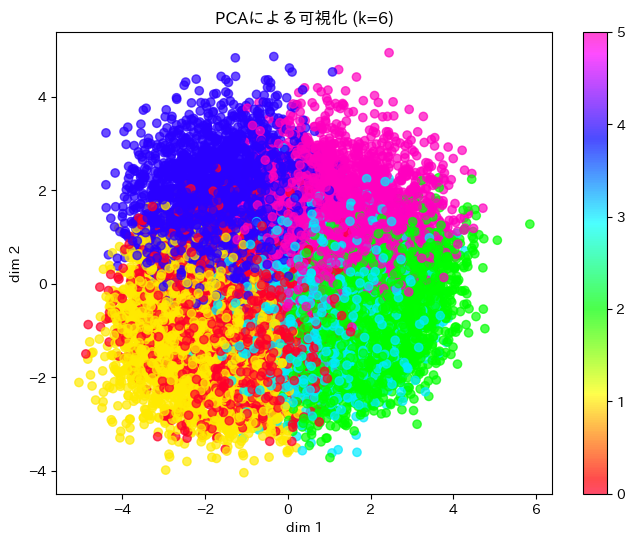

In [20]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_embeddings)
df_embeddings_pca = pca.transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_embeddings_pca[:, 0], df_embeddings_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCAによる可視化 (k={k})')
plt.colorbar()
plt.show()

### t-SNE

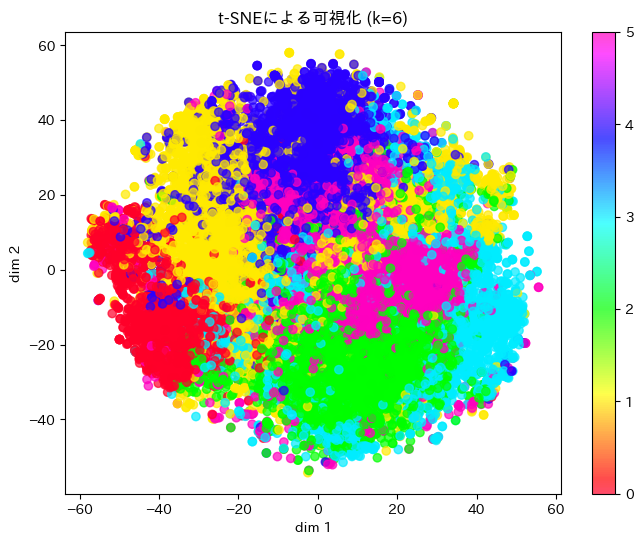

In [21]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNEによる可視化 (k={k})')
plt.colorbar()
plt.show()

# in 1min

### UMAP

In [22]:
'''
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0)
df_wrime_features_umap = umap_obj.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAPによる可視化 (k={k})')
plt.colorbar()
plt.show()
'''

"\nimport umap\n\n# UMAP\numap_obj = umap.UMAP(n_components=2, random_state=0)\ndf_wrime_features_umap = umap_obj.fit_transform(df_embeddings)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\nplt.title(f'UMAPによる可視化 (k={k})')\nplt.colorbar()\nplt.show()\n"

---

# 感情カテゴリとつぶやき分散表現の関係

In [23]:
# clusters/emotion_6clusters.tsvを読み込み
df_clusters = pd.read_csv('clusters/emotion_6clusters.tsv', sep='\t', header=None)
# 変換
emotion_clusters = df_clusters[0].tolist()
emotion_clusters = [int(x) for x in emotion_clusters]
df_emotion_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])

In [24]:
df_emotion_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


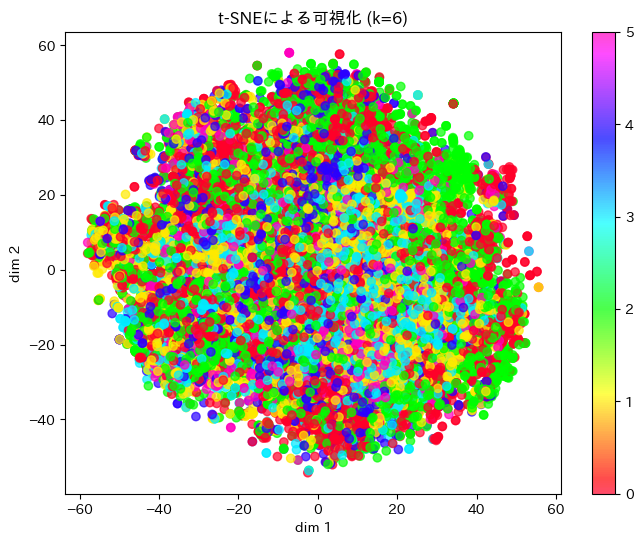

In [25]:
# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNEによる可視化 (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

---

### 感情カテゴリを正解ラベルとして、つぶやき分散表現から学習

In [26]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clusters], ignore_index=True, axis=1)
df_embeddings_clusters


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,-0.187810,-0.029080,-0.679696,-0.096203,-0.572932,0.123853,0.143044,-0.762576,0.458638,...,-0.237779,0.491252,-0.419029,-0.075512,-0.592340,0.193194,-0.133851,0.135610,-0.031739,1
1,train,-0.149567,-0.022400,-0.615799,0.016267,-0.396527,-0.197779,0.109518,-0.546292,0.597834,...,-0.025395,0.147794,-0.278225,0.022704,-0.668020,0.255528,0.133077,0.328987,0.117896,4
2,train,-0.311794,-0.270892,-0.197350,-0.209051,-0.546433,-0.014661,0.223735,-0.550872,0.491359,...,0.278841,0.185260,-0.336379,-0.075834,-0.622449,0.380931,0.119956,0.142896,0.248715,0
3,train,-0.630534,-0.395861,-0.183580,-0.364227,-0.412566,-0.315360,-0.353433,-0.409644,0.250649,...,0.360706,0.126539,0.019109,-0.378567,-0.260029,0.320159,-0.078728,-0.447909,0.303627,2
4,train,0.077433,0.486812,0.400255,-0.118953,-0.420790,0.276861,0.175705,0.012405,0.381621,...,0.290340,0.316523,-0.422998,0.154457,-0.203230,0.572079,-0.196266,-0.114936,0.165855,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,-0.440247,0.343116,-0.464327,-0.172980,-0.168927,0.103123,-0.081471,-0.568790,0.598139,...,0.288895,-0.069333,-0.174455,-0.041003,-1.087263,-0.004808,-0.181455,-0.529113,0.157269,0
18233,train,-0.457918,-0.223783,-0.269040,-0.105960,-0.205013,-0.145591,0.136372,-0.441816,0.460735,...,0.274615,0.071129,-0.204481,0.013164,-0.543513,-0.064153,0.105958,-0.333773,0.086513,2
18234,train,-0.196639,-0.059835,-0.205472,-0.013719,-0.446943,0.608693,0.201350,-0.619538,0.838737,...,0.127369,0.218654,-0.184477,0.176848,-0.290259,-0.212824,-0.175552,-0.291016,0.201506,0
18235,train,-0.338175,-0.160425,-0.424109,-0.201432,-0.313839,0.206797,0.237298,-0.625516,0.581621,...,-0.043867,0.258578,-0.170854,-0.029221,-0.750368,0.196065,-0.177157,-0.435295,0.015229,2


In [27]:
# train / test に分割する
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [28]:
import xgboost as xgb

# xgboostの入力データを作成
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.70779	test-mlogloss:1.67784
[1]	train-mlogloss:1.65726	test-mlogloss:1.60520
[2]	train-mlogloss:1.62232	test-mlogloss:1.56249
[3]	train-mlogloss:1.59503	test-mlogloss:1.53000
[4]	train-mlogloss:1.57248	test-mlogloss:1.50712
[5]	train-mlogloss:1.55334	test-mlogloss:1.48448
[6]	train-mlogloss:1.53630	test-mlogloss:1.46325
[7]	train-mlogloss:1.52085	test-mlogloss:1.44754
[8]	train-mlogloss:1.50666	test-mlogloss:1.43404
[9]	train-mlogloss:1.49348	test-mlogloss:1.42507
[10]	train-mlogloss:1.48110	test-mlogloss:1.41008
[11]	train-mlogloss:1.46969	test-mlogloss:1.40018
[12]	train-mlogloss:1.45900	test-mlogloss:1.39047
[13]	train-mlogloss:1.44892	test-mlogloss:1.38198
[14]	train-mlogloss:1.43946	test-mlogloss:1.37333
[15]	train-mlogloss:1.43037	test-mlogloss:1.36456
[16]	train-mlogloss:1.42181	test-mlogloss:1.35657
[17]	train-mlogloss:1.41392	test-mlogloss:1.34717
[18]	train-mlogloss:1.40648	test-mlogloss:1.33996
[19]	train-mlogloss:1.39927	test-mlogloss:1.33403
[20]	train

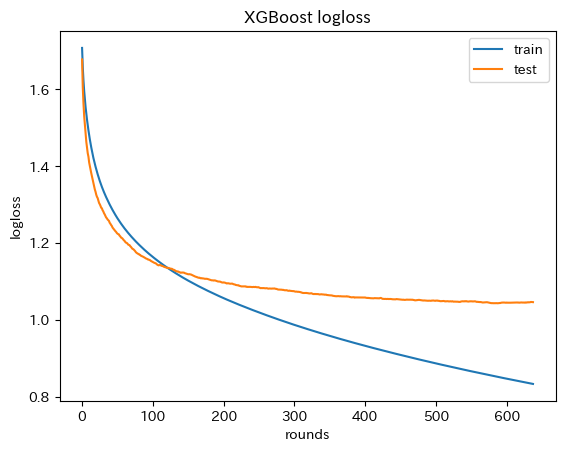

In [29]:
# モデル
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.5,
}

history = dict()

# 学習
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=50)

# 予測
preds_labels = model.predict(test_data)

# グラフ描写
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

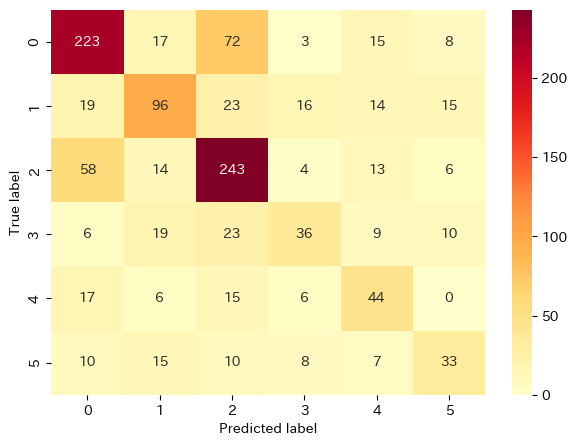

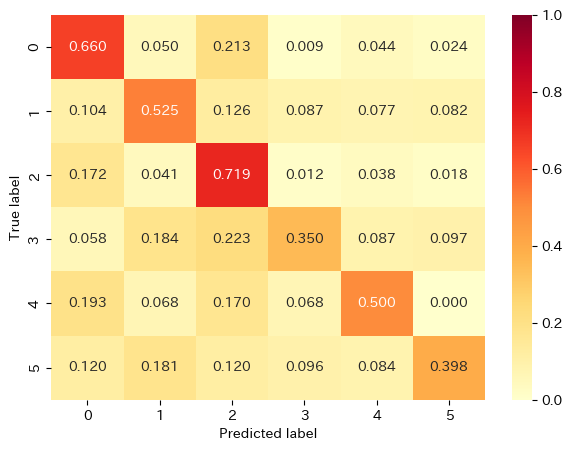

              precision    recall  f1-score   support

           0      0.670     0.660     0.665       338
           1      0.575     0.525     0.549       183
           2      0.630     0.719     0.671       338
           3      0.493     0.350     0.409       103
           4      0.431     0.500     0.463        88
           5      0.458     0.398     0.426        83

    accuracy                          0.596      1133
   macro avg      0.543     0.525     0.530      1133
weighted avg      0.592     0.596     0.592      1133



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

k = 6  
'cl-tohoku/bert-base-japanese-whole-word-masking' は accuracy 60%  
'cl-tohoku/bert-base-japanese-v2' は accuracy 58.6%

In [31]:
# 間違って予測された文章のindexを取得
wrong_preds = np.where(test_labels != preds_labels)[0]

# 間違って予測された文章を5個表示
for i in wrong_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

友達がハワイで挙式して、森で撮った写真がすごく素敵で羨ましかった。長い髪はゆる巻きダウンにして、お花の冠とベールをつけてるかんじ。木漏れ日を見上げる姿が可愛かったなぁ。
True label: 0
Predicted label: 2.0
---
今日また、ふらりと入れる店が増えた。お酒もご飯も美味しかったし、何より、何となく温かい店だった。
True label: 5
Predicted label: 0.0
---
ホットカーペットに寝っ転がってうとうとするのサイコー。
True label: 3
Predicted label: 1.0
---
ん？ONE PIECEの歌がなんかヘン。
True label: 2
Predicted label: 3.0
---
久しぶりにヤツが来た。ちきしょう、油断してた…コルセット生活、再開!!(T_T)
True label: 3
Predicted label: 0.0
---


---

### pretrained bertのクラスタリングと感情カテゴリーの一致度

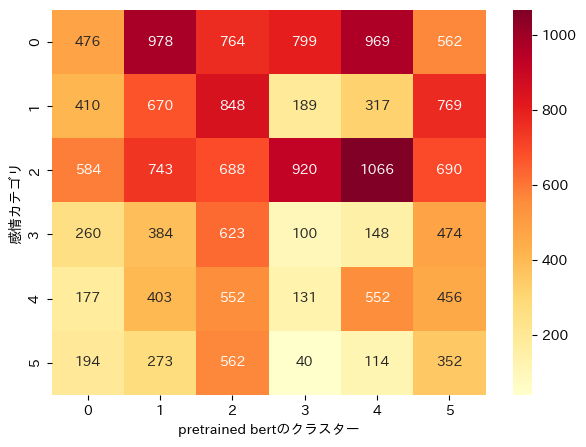

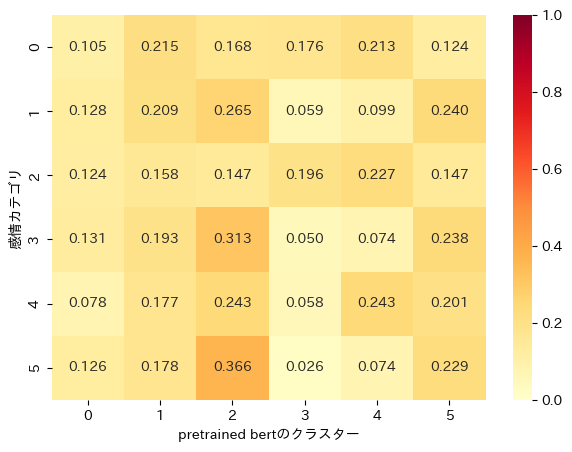

In [32]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])

# pretrained bertのクラスタリングとemotionのクラスタリングの比較
cm = confusion_matrix(df_emotion_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('pretrained bertのクラスター')
plt.ylabel('感情カテゴリ')
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('pretrained bertのクラスター')
plt.ylabel('感情カテゴリ')
plt.show()